# 02 – Reporte de resultados

En este notebook comparamos cinco modelos entrenados para predecir cancelaciones de hotel:

- Decision Tree  
- Logistic Regression  
- Gradient Boost  
- Random Forest  
- MLP (TensorFlow)

Nuestra métrica principal es la **AUC-ROC**, porque:
1. **Desbalance de clases**  
2. **Ranking vs umbral fijo**  
3. **Robustez** frente a distintos thresholds  

> **Resultado**: Random Forest obtiene la mayor AUC-ROC (0.954), por lo que será nuestro candidato final.

## 1. Comparativa de métricas
En esta sección usamos un selector interactivo para ordenar la tabla de métricas (_Accuracy, Precision, Recall, F1-score, AUC-ROC_) y ver de forma dinámica cuál modelo rinde mejor según cada criterio.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, Dropdown

# carga tus métricas
df = pd.read_csv("../reports/final_metrics.csv")
df = df.rename(columns={"roc_auc":"AUC-ROC"})
sns.set_style("darkgrid")

# define métricas disponibles
metrics = ["accuracy", "precision", "recall", "f1_score", "AUC-ROC"]

@interact(métrica=Dropdown(options=metrics, description="Métrica"))
def mostrar_tabla(métrica):
    display(
      df[["model", métrica]]
        .sort_values(métrica, ascending=False)
        .style.format({métrica:"{:.3f}"})
    )

interactive(children=(Dropdown(description='Métrica', options=('accuracy', 'precision', 'recall', 'f1_score', …

El selector de arriba nos permite ordenar dinámicamente la tabla por cualquier métrica (Accuracy, Precisión, Recall, F1-score o AUC-ROC).  
A continuación, se observa cómo Random Forest lidera siempre, y especialmente en AUC-ROC.

In [4]:
# Creamos el DataFrame de AUC-ROC ordenado de mayor a menor
df_auc = (
    df[["model", "AUC-ROC"]]
    .sort_values("AUC-ROC", ascending=False)
    .reset_index(drop=True)
)
df_auc

,model,AUC-ROC
0,random_forest,0.954130
1,gradient_boost,0.944649
2,decision_tree,0.923065
3,logistic_regression,0.897812


## 2. Visualización de AUC-ROC
A continuación presentamos un barplot ordenado de mayor a menor AUC-ROC. Sobre cada barra anotamos su valor numérico para facilitar la lectura.

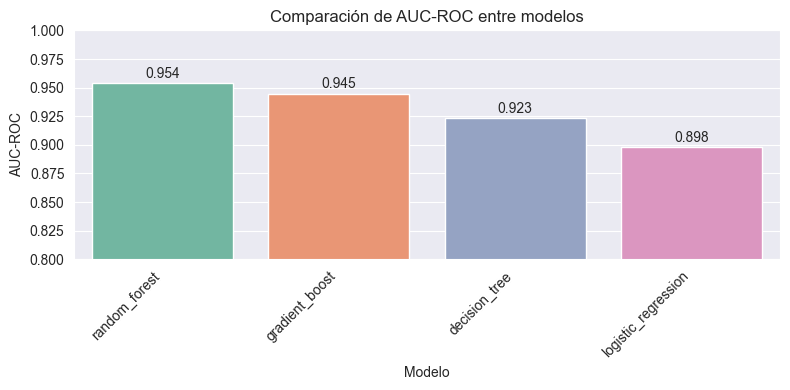

In [10]:
import seaborn as sns

plt.figure(figsize=(8,4))
ax = sns.barplot(
    data=df_auc,
    x="model", y="AUC-ROC",
    hue="model",     
    palette="Set2",
    legend=False      # quitamos la leyenda duplicada
)

# Anotamos los valores encima de cada barra
for i, row in df_auc.iterrows():
    ax.text(
        i, row["AUC-ROC"] + 0.002,
        f"{row['AUC-ROC']:.3f}",
        ha="center", va="bottom"
    )
ax.set_ylim(0.8, 1.0)
ax.set_xlabel("Modelo")
ax.set_ylabel("AUC-ROC")
ax.set_title("Comparación de AUC-ROC entre modelos")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 3. Curvas ROC individuales
Para entender la capacidad de ranking de cada modelo, dibujamos su curva ROC y mostramos su AUC en la leyenda. Usa el selector para cambiar de modelo.

In [9]:
from ipywidgets import Dropdown, interact
import matplotlib.pyplot as plt

# Preparamos un dict con los CSV que se guardaron en reports/roc_csv
import os
roc_dir = "../reports/roc_csv"
roc_files = {
    os.path.splitext(f)[0].replace("roc_", ""): os.path.join(roc_dir, f)
    for f in os.listdir(roc_dir) if f.endswith(".csv")
}

@interact(model=Dropdown(options=list(roc_files.keys()), description="Modelo"))
def plot_roc(model):
    df_roc = pd.read_csv(roc_files[model])
    # filtramos la fila del AUC
    auc_row = df_roc[df_roc["fpr"] == "AUC"]
    df_curve = df_roc[df_roc["fpr"] != "AUC"].astype(float)
    plt.figure(figsize=(6,6))
    auc_val = float(auc_row["tpr"].iloc[0])
    plt.plot(df_curve["fpr"], df_curve["tpr"], label=f"{model} (AUC={auc_val:.3f})")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {model}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='Modelo', options=('decision_tree', 'gradient_boost', 'logistic_reg…

> **Interpretación:** La curva más cercana a la esquina superior izquierda indica mejor separación entre clases. Vemos, por ejemplo, que Random Forest presenta la línea más “elevada” a lo largo de todo el rango de FPR.

## 4. Conclusión
Random Forest no sólo alcanza la AUC-ROC más alta (0.954), sino que su curva ROC demuestra un rendimiento consistentemente superior en todos los thresholds. Será nuestro modelo candidato para producción.